# Planar Data Classification with One Hidden Layer

Welcome to your week 3 programming assignment. It's time to build your first neural network, which will have a hidden layer. You will see a big difference between this model and the one you implemented using logistic regression. 

**You will learn how to:**
- Implement a $2$-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as $\tanh$ 
- Compute the cross entropy loss 
- Implement forward and backward propagation

## 1 - Packages

In [1]:
push!(LOAD_PATH, pwd())
using HDF5
using Random
using PyPlot
using LaTeXStrings
using LinearAlgebra 
using Statistics
using Printf
using ScikitLearn
using planar_utils
using testCases_v2
using LoopVectorization


@sk_import linear_model: LogisticRegression

PyObject <class 'sklearn.linear_model._logistic.LogisticRegression'>

## 2 - Dataset

First, let's get the dataset you will work on. The following code will load a "flower" $2$-class dataset into variables `X` and `Y`.

In [2]:
fid = h5open("data.h5","r")
@show keys(fid)

# Use transpose to make sure each column is a sample.
X = Float64.(fid["X"][:, :])'
Y = Float64.(fid["Y"][:, :])'
@show size(X)
@show size(Y);

keys(fid) = ["X", "Y"]
size(X) = (2, 400)
size(Y) = (1, 400)


Visualize the dataset using `matplotlib`. The data looks like a "flower" with some red (label `y=0`) and some blue (`y=1`) points. Your goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

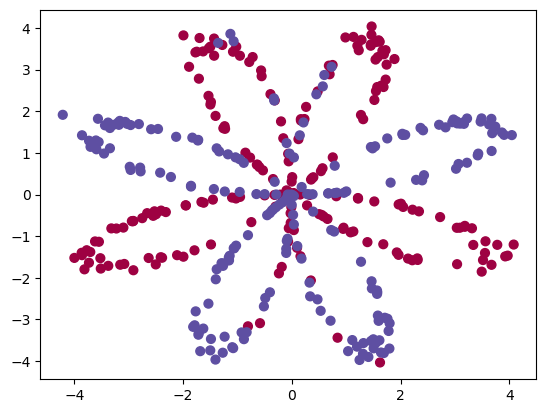

In [3]:
# Visualize the data:
plt.scatter(X[1, :], X[2, :], c=Y, s=40, cmap=plt.cm.Spectral);

You have:
- a `Float64` array (matrix) `X` that contains your features `(x1, x2)`
- a `Float64` array (vector) `Y` that contains your labels `(red:0, blue:1)`.

Lets first get a better sense of what our data is like. 

**Exercise**: How many training examples do you have? In addition, what is the `size` of the variables `X` and `Y`? 

In [4]:
### START CODE HERE ### (≈ 3 lines of code)
shape_X = size(X)
shape_Y = size(Y)
m = shape_X[end]  # training set size
### END CODE HERE ###

@printf("The shape of X is: (%d, %d)\n", shape_X[1], shape_X[2])
@printf("The shape of Y is: (%d, %d)\n", shape_Y[1], shape_Y[2])
@printf("I have m = %d training examples!\n", m)

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


**Expected Output**:
       
```
The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!
```

## 3 - Simple Logistic Regression

Before building a full neural network, let's first see how logistic regression performs on this problem. You can use `ScikitLearn`'s built-in functions to do that. Run the code below to train a logistic regression classifier on the dataset.

In [5]:
model = LogisticRegression(fit_intercept=true)
fit!(model, X', vec(Y));

You can now plot the decision boundary of these models. Run the code below.

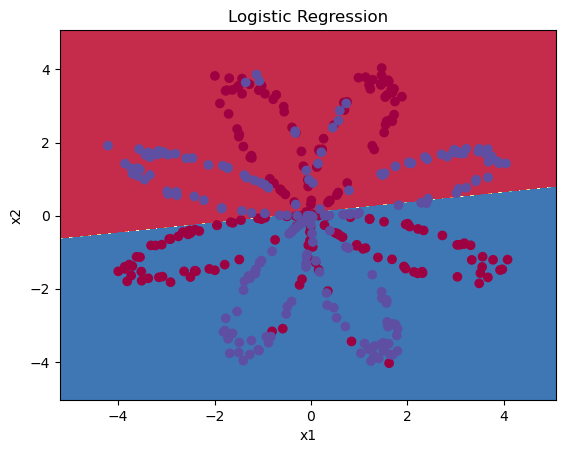

Accuracy of logistic regression: 47% (percentage of correctly labelled datapoints)

In [6]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(X -> predict(model, X), X, Y)
plt.title("Logistic Regression")


# Print accuracy
LR_predictions = predict(model, X')
@printf("Accuracy of logistic regression: %d%% (percentage of correctly labelled datapoints)", 
    Int(round((Y * LR_predictions + (1 .- Y) * (1 .- LR_predictions))[1] / length(Y) * 100)))

**Expected Output**:

|**accuracy**|
|------------|
|`47 %`      |

**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now! 

## 4 - Neural Network Model

Logistic regression did not work well on the "flower dataset". You are going to train a Neural Network with a single hidden layer.

**Here is our model**:
![](images/classification_kiank.png)

**Mathematically**:

For one example $x^{(i)}$:
\begin{align}
    z^{[1] (i)}   &=  W^{[1]} x^{(i)} + b^{[1]}         \tag{1} \\ 
    a^{[1] (i)}   &= \tanh(z^{[1] (i)})                 \tag{2} \\ 
    z^{[2] (i)}   &= W^{[2]} a^{[1] (i)} + b^{[2]}      \tag{3} \\ 
    \hat{y}^{(i)} &= a^{[2] (i)} = \sigma(z^{ [2] (i)}) \tag{4} \\
    y^{(i)}_{prediction} & = \begin{cases} 
                                 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 
                                 0 & \mbox{otherwise } 
                             \end{cases}\tag{5}
\end{align}

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
\begin{equation}
J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}
\end{equation}

**Reminder**: The general methodology to build a Neural Network is to:
1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
2. Initialize the model's parameters
3. Loop:
    - Implement forward propagation
    - Compute loss
    - Implement backward propagation to get the gradients
    - Update parameters (gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

### 4.1 - Defining the neural network structure

**Exercise**: Define three variables:
- `n_x`: the size of the input layer
- `n_h`: the size of the hidden layer (set this to 4) 
- `n_y`: the size of the output layer

**Hint**: Use shapes of `X` and `Y` to find `n_x` and `n_y`. Also, hard code the hidden layer size to be $4$.

In [7]:
# GRADED FUNCTION: layer_sizes

"""
Arguments:
X -- input dataset of shape (input size, number of examples)
Y -- labels of shape (output size, number of examples)

Returns:
n_x -- the size of the input layer
n_h -- the size of the hidden layer
n_y -- the size of the output layer
    """
function layer_sizes(X, n_h, Y)
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = size(X)[1] # size of input layer
    n_y = size(Y)[1] # size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)
end

layer_sizes

In [8]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, 4, Y_assess)
print("The size of the input layer is: n_x = ", string(n_x), "\n")
print("The size of the hidden layer is: n_h = ", string(n_h), "\n")
print("The size of the output layer is: n_y = ", string(n_y), "\n")

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


**Expected Output** (these are not the sizes you will use for your network, they are just used to assess the function you've just coded).

|**`n_x`**|**`n_h`**|**`n_y`**|
|---------|---------|---------|
|  `5`    |  `4`    |  `2`    |

### 4.2 - Initialize the model's parameters

**Exercise**: Implement the function `initialize_parameters()`.

**Instructions**:
- Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.
- You will initialize the weights matrices with random values. 
    - Use: `randn(a,b) .* 0.01` to randomly initialize a matrix of shape `(a,b)`.
- You will initialize the bias vectors as zeros. 
    - Use: `zeros(a,b)` to initialize a matrix of shape `(a,b)` with zeros.

In [9]:
# GRADED FUNCTION: initialize_parameters

"""
Argument:
n_x -- size of the input layer
n_h -- size of the hidden layer
n_y -- size of the output layer

Returns:
params -- Julia dictionary containing your parameters:
                W1 -- weight matrix of shape (n_h, n_x)
                b1 -- bias vector of shape (n_h, 1)
                W2 -- weight matrix of shape (n_y, n_h)
                b2 -- bias vector of shape (n_y, 1)
"""
function initialize_parameters(n_x, n_h, n_y)
    rng = MersenneTwister(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = randn(rng, (n_h, n_x)) * 0.01
    b1 = zeros(n_h, 1)
    W2 = randn(rng, (n_y, n_h)) * 0.01
    b2 = zeros(n_y, 1)
    ### END CODE HERE ###
    
    @assert size(W1) == (n_h, n_x)
    @assert size(b1) == (n_h, 1)
    @assert size(W2) == (n_y, n_h)
    @assert size(b2) == (n_y, 1)
    
    parameters = Dict(
        "W1"=> W1,
        "b1"=> b1,
        "W2"=> W2,
        "b2"=> b2
    )
    
    return parameters
end

initialize_parameters

In [10]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = ", string(parameters["W1"]), "\n")
print("b1 = ", string(parameters["b1"]), "\n")
print("W2 = ", string(parameters["W2"]), "\n")
print("b2 = ", string(parameters["b2"]), "\n")

W1 = [0.007396206598864331 -0.0067561560740237135; -0.007445071021408705 0.005566463333701307; -0.006085075626113596 -0.008615844731669183; -0.017234565107957983 0.005180851077313978]
b1 = [0.0; 0.0; 0.0; 0.0]
W2 = [0.012482298080972934 0.011691129549524617 -0.0009301787986362445 -0.012924032572712177]
b2 = [0.0]


**Expected Output**:

```
W1 = [0.007396206598864331 -0.0067561560740237135; -0.007445071021408705 0.005566463333701307; -0.006085075626113596 -0.008615844731669183; -0.017234565107957983 0.005180851077313978]
b1 = [0.0; 0.0; 0.0; 0.0]
W2 = [0.012482298080972934 0.011691129549524617 -0.0009301787986362445 -0.012924032572712177]
b2 = [0.0]
```

### 4.3 - The Loop

**Question**: Implement `forward_propagation()`.

**Instructions**:
- Look above at the mathematical representation of your classifier.
- You can use the function `sigmoid()`. It is built-in (imported) in the notebook.
- You can use the function `tanh()`. It is buit-in in Julia.
- The steps you have to implement are:
    1. Retrieve each parameter from the dictionary `parameters` (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.

In [11]:
# GRADED FUNCTION: forward_propagation

"""
Argument:
X -- input data of size (n_x, m)
parameters -- Julia dictionary containing your parameters (output of initialization function)

Returns:
A2 -- The sigmoid output of the second activation
cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
"""
function forward_propagation(X, parameters)
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###

    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = W1 * X .+ b1
    A1 = tanh.(Z1)
    Z2 = W2 * A1 .+ b2
    A2 = sigmoid.(Z2)
    ### END CODE HERE ###
    
    @assert size(A2) == (1, size(X)[2])
    
    cache = Dict(
        "Z1" => Z1,
        "A1" => A1,
        "Z2" => Z2,
        "A2" => A2
    )
    
    return A2, cache
end

forward_propagation

In [12]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(mean(cache["Z1"]), "\n", mean(cache["A1"]), "\n", mean(cache["Z2"]), "\n", mean(cache["A2"]))

0.24930268641508124
0.2249188520976957
-1.3049997230370678
0.21332477467479938

**Expected Output**:

```
0.24930268641508124
0.2249188520976957
-1.3049997230370678
0.21332477467479938
```

Now that you have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, you can compute the cost function as follows:

\begin{equation}
J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \left( \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \right) \small\tag{13}
\end{equation}

**Exercise**: Implement `compute_cost()` to compute the value of the cost $J$.

**Instructions**:
- There are many ways to implement the cross-entropy loss. To help you, we give you how we would have implemented
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```julia
logprobs = log.(A2) * Y'
cost = - sum(logprobs)
```
(However, since Julia does not require vectorization to speed up computation, you can write a `for` loop with `@avx` macro to speed up computation).

Note that if you use `*`, the result will be a 2D array.  We can use `dropdims()` to remove redundant dimensions (in the case of single float, this will be reduced to a zero-dimension array). We can cast the array as a type `float` using `float()`.

In [13]:
# GRADED FUNCTION: compute_cost

"""
Computes the cross-entropy cost given in equation (13)

Arguments:
A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
Y -- "true" labels vector of shape (1, number of examples)

Returns:
cost -- cross-entropy cost given equation (13)
"""
function compute_cost(A2, Y)
    m = size(Y)[2] # number of example

    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 2 lines of code)
    @avx logprobs = log.(A2) * Y' + log.(1 .- A2) * (1 .- Y)'
    cost = - logprobs / m
    ### END CODE HERE ###
    cost = dropdims(cost, dims=size(cost)[end])  # makes sure cost is the dimension we expect. 
                                                 # E.g., turns [[17]] into 17 
    cost = Float64(cost[1])
    @assert isa(cost, Float64)
    return cost
end

compute_cost

In [14]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = ", string(compute_cost(A2, Y_assess)))

cost = 0.6932476810445216

**Expected Output**:

|**`cost`**|
|----------|
|`0.6932476810445216`|

Using the cache computed during forward propagation, you can now implement backward propagation.

**Question**: Implement the function `backward_propagation()`.

**Instructions**:
Backpropagation is usually the hardest (most mathematical) part in deep learning. To help you, here again is the slide from the lecture on backpropagation. You'll want to use the six equations on the right of this slide, since you are building a vectorized implementation.  

![](images/grad_summary.png)

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

Tips:
- To compute `dZ1` you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the $\tanh$ activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute $g^{[1]'}(Z^{[1]})$ using `1 .- (A1 .^ 2)`.

In [15]:
# GRADED FUNCTION: backward_propagation

"""
Implement the backward propagation using the instructions above.

Arguments:
parameters -- python dictionary containing our parameters 
cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
X -- input data of shape (2, number of examples)
Y -- "true" labels vector of shape (1, number of examples)

Returns:
grads -- Julia dictionary containing your gradients with respect to different parameters
"""
function backward_propagation(parameters, cache, X, Y)
    m = size(X)[2]

    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache["A1"]
    A2 = cache["A2"]
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    dZ2 = (A2 - Y) ./ m # Andrew's formula is wrong.
    dW2 = dZ2 * A1'
    db2 = [sum(dZ2)]
    dZ1 = (W2' * dZ2) .* (1 .- A1 .^ 2) 
    dW1 = dZ1 * X'
    db1 = sum(dZ1, dims=2)
    ### END CODE HERE ###
    
    grads = Dict(
        "dW1" => dW1,
        "db1" => db1,
        "dW2" => dW2,
        "db2" => db2
    )
    
    return grads
end

backward_propagation

In [16]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
println("dW1 = ", string(grads["dW1"]))
println("db1 = ", string(grads["db1"]))
println("dW2 = ", string(grads["dW2"]))
println("db2 = ", string(grads["db2"]))

dW1 = [9.87203308017296e-5 0.0012406350500857254; 8.381554549421761e-5 0.001064077200489438; -5.198415034223501e-5 -0.0006463141363505; -0.00021510731917585022 -0.0026866004708357523]
db1 = [0.001762013336578853; 0.0015099480049211977; -0.000917363389783989; -0.003814217873784082]
dW2 = [0.0007884060322565666 0.017654290819959867 -0.0008416578262350665 -0.0102252703120983]
db2 = [-0.16655712]


**Expected output**:

```
dW1 = [9.87203308017296e-5 0.0012406350500857254; 8.381554549421761e-5 0.001064077200489438; -5.198415034223501e-5 -0.0006463141363505; -0.00021510731917585022 -0.0026866004708357523]
db1 = [0.001762013336578853; 0.0015099480049211977; -0.000917363389783989; -0.003814217873784082]
dW2 = [0.0007884060322565666 0.017654290819959867 -0.0008416578262350665 -0.0102252703120983]
db2 = -0.16655712
```

**Question**: Implement the update rule. Use gradient descent. You have to use (`dW1`, `db1`, `dW2`, `db2`) in order to update (`W1`, `b1`, `W2`, `b2`).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

![](images/sgd.gif)
![](images/sgd_bad.gif)

In [17]:
# GRADED FUNCTION: update_parameters

"""
Updates parameters using the gradient descent update rule given above

Arguments:
parameters -- Julia dictionary containing your parameters 
grads -- Julia dictionary containing your gradients 

Returns:
parameters -- Julia dictionary containing your updated parameters 
"""
function update_parameters(parameters, grads; learning_rate=1.2)

    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ## END CODE HERE ###

    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate .* dW1
    b1 = b1 - learning_rate .* db1
    W2 = W2 - learning_rate .* dW2
    b2 = b2 - learning_rate .* db2
    ### END CODE HERE ###
    
    parameters = Dict(
        "W1" => W1,
        "b1" => b1,
        "W2" => W2,
        "b2" => b2
    )
    
    return parameters
end

update_parameters

In [18]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

println("W1 = ", string(parameters["W1"]))
println("b1 = ", string(parameters["b1"]))
println("W2 = ", string(parameters["W2"]))
println("b2 = ", string(parameters["b2"]))

W1 = [-0.006430254000000001 0.019367176; -0.024104584 0.039780522; -0.016539728 -0.02096177; 0.010468644000000001 -0.059901406]
b1 = [-1.0242075594e-6; 1.2737394764000001e-5; 8.329968070000001e-7; -3.2013683623999996e-6]
W2 = [-0.010410811195319999 -0.044632846044 0.01758030714 0.047471133804]
b2 = [0.0001045662146]


**Expected Output**:

```
W1 = [-0.006430254000000001 0.019367176; -0.024104584 0.039780522; -0.016539728 -0.02096177; 0.010468644000000001 -0.059901406]
b1 = [-1.0242075594e-6; 1.2737394764000001e-5; 8.329968070000001e-7; -3.2013683623999996e-6]
W2 = [-0.010410811195319999 -0.044632846044 0.01758030714 0.047471133804]
b2 = [0.0001045662146]
```

### 4.4 - Integrate parts 4.1, 4.2 and 4.3 in `nn_model()` 

In [19]:
# GRADED FUNCTION: nn_model

"""
Arguments:
X -- dataset of shape (2, number of examples)
Y -- labels of shape (1, number of examples)
n_h -- size of the hidden layer
num_iterations -- Number of iterations in gradient descent loop
print_cost -- if true, print the cost every 1000 iterations

Returns:
parameters -- parameters learnt by the model. They can then be used to predict.
"""
function nn_model(X, Y, n_h; num_iterations=10000, print_cost=false)
    Random.seed!(3)
    n_x = layer_sizes(X, n_h, Y)[begin]
    n_y = layer_sizes(X, n_h, Y)[end]
    
    # Initialize parameters
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Loop (gradient descent)

    for i ∈ 1: num_iterations
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y". Outputs: "cost".
        cost = compute_cost(A2, Y)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost && i % 1000 == 0
            @printf("Cost after iteration %d: %f\n", i, cost)
        end
    end
    return parameters
end

nn_model

In [20]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4; num_iterations=10000, print_cost=true)
println("W1 = ", string(parameters["W1"]))
println("b1 = ", string(parameters["b1"]))
println("W2 = ", string(parameters["W2"]))
println("b2 = ", string(parameters["b2"]))

Cost after iteration 1000: 0.000571
Cost after iteration 2000: 0.000251
Cost after iteration 3000: 0.000158
Cost after iteration 4000: 0.000114
Cost after iteration 5000: 0.000089
Cost after iteration 6000: 0.000073
Cost after iteration 7000: 0.000061
Cost after iteration 8000: 0.000053
Cost after iteration 9000: 0.000047
Cost after iteration 10000: 0.000042
W1 = [-0.08388875688087397 3.459032814545565; -0.12759626029668306 3.992826709766011; 0.0889917419523807 -3.479648413914068; 0.17368069688103743 -4.674480926689385]
b1 = [-0.5918461014665024; -0.7021701757411863; 0.5983439846697929; 0.8369741772526933]
W2 = [3.7208697346773025 4.378372348003103 -3.7456532897034642 -5.273463053485422]
b2 = [0.24981301794538655]


**Expected Output:**

```
Cost after iteration 1000: 0.000571
...
Cost after iteration 10000: 0.000042
W1 = [-0.08388875688087397 3.459032814545565; -0.12759626029668306 3.992826709766011; 0.0889917419523807 -3.479648413914068; 0.17368069688103743 -4.674480926689385]
b1 = [-0.5918461014665024; -0.7021701757411863; 0.5983439846697929; 0.8369741772526933]
W2 = [3.7208697346773025 4.378372348003103 -3.7456532897034642 -5.273463053485422]
b2 = [0.24981301794538655]
```

### 4.5 Predictions

**Question**: Use your model to predict by building `predict()`.
Use forward propagation to predict results.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ \texttt{activation} > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
As an example, if you would like to set the entries of a matrix `X` to `0` and `1` based on a threshold you would do: ```X_new = (X > threshold)```

In [21]:
# GRADED FUNCTION: predict

"""
Using the learned parameters, predicts a class for each example in X

Arguments:
parameters -- python dictionary containing your parameters 
X -- input data of size (n_x, m)

Returns
predictions -- vector of predictions of our model (red: 0 / blue: 1)
"""
function my_predict(parameters, X)
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 .> 0.5)
    ### END CODE HERE ###
    return predictions
end

my_predict

In [22]:
parameters, X_assess = predict_test_case()

predictions = my_predict(parameters, X_assess)
println("predictions mean = ", string(mean(predictions)))

predictions mean = 0.0


It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.

In [23]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, 4; num_iterations=10000, print_cost=true);

Cost after iteration 1000: 0.532022
Cost after iteration 2000: 0.524928
Cost after iteration 3000: 0.521734
Cost after iteration 4000: 0.519709
Cost after iteration 5000: 0.517989
Cost after iteration 6000: 0.516435
Cost after iteration 7000: 0.515034
Cost after iteration 8000: 0.513782
Cost after iteration 9000: 0.512667
Cost after iteration 10000: 0.511674


Dict{String,Array{Float64,2}} with 4 entries:
  "W2" => [2.9847 2.30089 3.18579 -2.57498]
  "W1" => [7.36392 3.17749; -8.06235 2.34343; -10.1358 -8.46431; -8.78497 7.756…
  "b2" => [0.0100291]
  "b1" => [0.00566225; -0.329297; -0.0247687; -0.00175022]

In [24]:
# Print accuracy
predictions = my_predict(parameters, X)
@printf("Accuracy: %f", ((Y * predictions') + (1 .- Y) * (1 .- predictions)')[1] / length(Y) * 100)

Accuracy: 67.000000

**Expected Output:**

```
Accuracy: 67.000000
```